Data preprocessing done
Linear model done
Boosting model done
MLP done
done


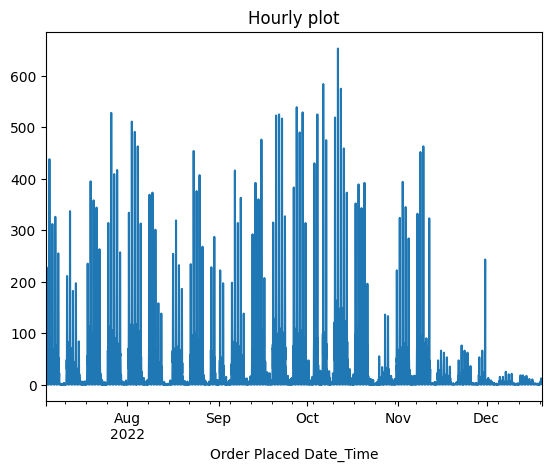

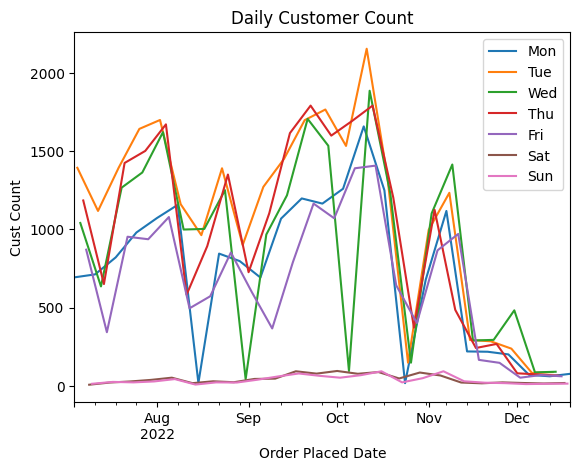

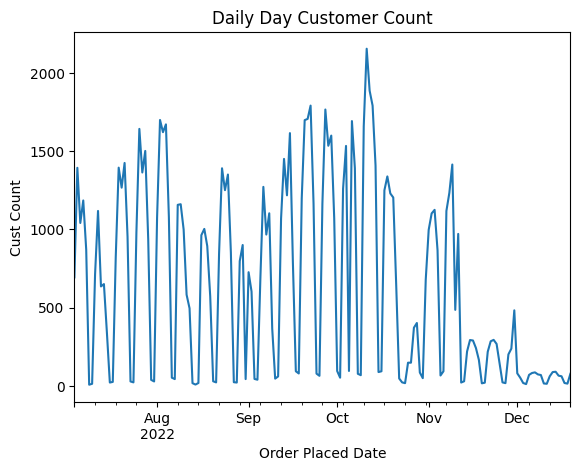

In [1]:
# Setting path
import sys
import os
# getting the name of the directory where the this file is present.
current = os.path.abspath('')
# Getting the parent directory 
parent = os.path.dirname(current)
# adding the parent directory to
# the sys.path.
sys.path.append(os.path.dirname(parent))

#Importing important libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import pickle
import holidays
import config
data_filename = 'CG_Hinjewadi_conjestion_data.pickle'


df_item = pd.read_pickle(config.DATA+'//data//'+data_filename)
#df_item_hourly = df_item.resample('H', on='Order Placed Date_Time').sum()
#df_item_daily = df_item.resample('D', on='Order Placed Date_Time').sum()

def date_features(dataset):
    if pd.infer_freq(dataset.index) == 'H':
        dataset['hour'] = dataset.index.hour
    dataset['date'] = dataset.index.day
    dataset['month'] = dataset.index.month
    #dataset['year'] = dataset.index.year
    dataset['dayofweek'] = dataset.index.dayofweek
    return dataset

# Adding date features
df_item_hourly_features = date_features(df_item)
# Add holidays and encoding as 0 and 1
df_item_hourly_features['holiday'] = pd.Series(df_item_hourly_features.index).apply(lambda x: holidays.CountryHoliday('IN',prov='KA').get(x)).values
df_item_hourly_features['holiday'] = df_item_hourly_features['holiday'].astype('bool').astype('int')

# Cyclic encoding function
def encode(dataset, col, max_val):
    dataset[col + '_sin'] = np.sin(2 * np.pi * dataset[col]/max_val)
    dataset[col + '_cos'] = np.cos(2 * np.pi * dataset[col]/max_val)
    dataset.drop(col,axis = 1, inplace = True)
    return dataset

# Encoding df
if pd.infer_freq(df_item_hourly_features.index) == 'H':
    df_item_hourly_features = encode(df_item_hourly_features,'hour',24)
df_item_hourly_features = encode(df_item_hourly_features,'date',31)
df_item_hourly_features = encode(df_item_hourly_features,'month',12)
df_item_hourly_features = encode(df_item_hourly_features,'dayofweek',7)

# # Encoding year as 0 and 1 
# df_item_hourly_features['year_enc'] = pd.get_dummies(df_item_hourly_features['year'])[2021]
# df_item_hourly_features.drop('year',axis = 1, inplace = True)

# Moving CreatedBy column at the end
df_item_hourly_features['CreatedBy'] = df_item_hourly_features.pop('CreatedBy')

# Removing last zeros
df_item_hourly_features= df_item_hourly_features.loc[df_item_hourly_features.index[0]: df_item_hourly_features[df_item_hourly_features['CreatedBy'] != 0].index[-1]]

#Plotting hourly data
fig1, ax1 = plt.subplots()
ax1 = df_item_hourly_features['CreatedBy'].plot(title = 'Hourly plot')
fig1 = ax1.get_figure()
fig1.savefig(config.DATA+'//data//ml_results_hinjewadi//_Hourly_plot.jpg')

#Plotting daily day data
fig2, ax2 = plt.subplots()
df_temp = df_item_hourly_features['CreatedBy'].resample('D').sum().to_frame()
ax2 = df_temp[df_temp.index.dayofweek == 0]['CreatedBy'].plot()
df_temp[df_temp.index.dayofweek == 1]['CreatedBy'].plot(ax=ax2)
df_temp[df_temp.index.dayofweek == 2]['CreatedBy'].plot(ax=ax2)
df_temp[df_temp.index.dayofweek == 3]['CreatedBy'].plot(ax=ax2)
df_temp[df_temp.index.dayofweek == 4]['CreatedBy'].plot(ax=ax2)
df_temp[df_temp.index.dayofweek == 5]['CreatedBy'].plot(ax=ax2)
df_temp[df_temp.index.dayofweek == 6]['CreatedBy'].plot(ax=ax2)
ax2.legend(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax2.set_xlabel('Order Placed Date')
ax2.set_ylabel('Cust Count')
ax2.set_title('Daily Customer Count')
fig2 = ax2.get_figure()
fig2.savefig(config.DATA+'//data//ml_results_hinjewadi//_Daily_day_plot.jpg')

#Plotting daily data
fig3, ax3 = plt.subplots()
ax3 = df_item_hourly_features['CreatedBy'].resample('D').sum().plot()
ax3.set_xlabel('Order Placed Date')
ax3.set_ylabel('Cust Count')
ax3.set_title('Daily Day Customer Count')
fig3 = ax3.get_figure()
fig3.savefig(config.DATA+'//data//ml_results_hinjewadi//_Daily_plot.jpg')

print('Data preprocessing done')

#Assigning X and y variables
X = df_item_hourly_features.iloc[:,0:-1]
y = df_item_hourly_features.iloc[:,-1]

from sklearn.model_selection import cross_validate
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error","r2","neg_mean_absolute_percentage_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    r2 = cv_results["test_r2"]
    mape = -cv_results["test_neg_mean_absolute_percentage_error"]*100
    # print(
    #     f"Model: {model}\n"
    #     f"R Squared Error: {r2.mean():.3f} +/- {r2.std():.3f}\n"
    #     # f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
    #     # f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}\n"
    #     # f"MAPE: {mape.mean():.3f} +/- {mape.std():.3f}"
    # )
    return r2.mean()

from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(n_splits=5,gap=0) 
linear_metric = {}
from sklearn import linear_model as lm
linear_metric['LinearRegression']  = evaluate(lm.LinearRegression(), X, y, cv=5)
linear_metric['LinearRegression_ts'] = evaluate(lm.LinearRegression(), X, y, cv=ts_cv)
linear_metric['Ridge'] = evaluate(lm.Ridge(), X, y, cv=5)
linear_metric['Ridge_ts'] = evaluate(lm.Ridge(), X, y, cv=ts_cv)
linear_metric['Ridge_0.5'] = evaluate(lm.Ridge(alpha=.5), X, y, cv=5)
linear_metric['Ridge_0.5_ts'] = evaluate(lm.Ridge(alpha=.5), X, y, cv=ts_cv)
linear_metric['Lasso'] = evaluate(lm.Lasso(), X, y, cv=5)
linear_metric['Lasso_ts'] = evaluate(lm.Lasso(), X, y, cv=ts_cv)
linear_metric['Lasso_0.1'] = evaluate(lm.Lasso(alpha=.1), X, y, cv=5)
linear_metric['Lasso_0.1_ts'] = evaluate(lm.Lasso(alpha=.1), X, y, cv=ts_cv)
linear_metric['ElasticNet'] = evaluate(lm.ElasticNet(random_state=0), X, y, cv=5)
linear_metric['ElasticNet_ts'] = evaluate(lm.ElasticNet(random_state=0), X, y, cv=ts_cv)
linear_metric['BayesianRidge'] = evaluate(lm.BayesianRidge(), X, y, cv=5)
linear_metric['BayesianRidge_ts'] = evaluate(lm.BayesianRidge(), X, y, cv=ts_cv)
linear_metric['SGDRegressorts'] = evaluate(lm.SGDRegressor(max_iter=1000, tol=1e-3), X, y, cv=5)
linear_metric['SGDRegressor_ts'] = evaluate(lm.SGDRegressor(max_iter=1000, tol=1e-3), X, y, cv=ts_cv)
linear_metric_df = pd.DataFrame(list(linear_metric.items()))

print('Linear model done')

from sklearn import ensemble as sk_en
from xgboost.sklearn import XGBRegressor

boosting_metric ={}

boosting_metric['GradientBoosting'] = evaluate(sk_en.GradientBoostingRegressor(), X, y, cv=5)
boosting_metric['GradientBoosting_ts'] = evaluate(sk_en.GradientBoostingRegressor(), X, y, cv=ts_cv)
boosting_metric['XGBoost'] = evaluate(XGBRegressor(), X, y, cv=5)
boosting_metric['XGBoost_ts'] = evaluate(XGBRegressor(), X, y, cv=ts_cv)
boosting_metric['HistGradientBoosting'] = evaluate(sk_en.HistGradientBoostingRegressor(), X, y, cv=5)
boosting_metric['HistGradientBoosting_ts'] = evaluate(sk_en.HistGradientBoostingRegressor(), X, y, cv=ts_cv)
boosting_metric['AdaBoost'] = evaluate(sk_en.AdaBoostRegressor(), X, y, cv=5)
boosting_metric['AdaBoost_ts'] = evaluate(sk_en.AdaBoostRegressor(), X, y, cv=ts_cv)
boosting_metric['RandomForest'] = evaluate(sk_en.RandomForestRegressor(), X, y, cv=5)
boosting_metric['RandomForest_ts'] = evaluate(sk_en.RandomForestRegressor(), X, y, cv=ts_cv)
boosting_metric['GradientBoosting'] = evaluate(sk_en.GradientBoostingRegressor(), X, y, cv=5)
boosting_metric['GradientBoosting_ts'] = evaluate(sk_en.GradientBoostingRegressor(), X, y, cv=ts_cv)
boosting_metric['XGBoost'] = evaluate(XGBRegressor(), X, y, cv=5)
boosting_metric['XGBoost_ts'] = evaluate(XGBRegressor(), X, y, cv=ts_cv)
boosting_metric['HistGradientBoosting'] = evaluate(sk_en.HistGradientBoostingRegressor(), X, y, cv=5)
boosting_metric['HistGradientBoosting_ts'] = evaluate(sk_en.HistGradientBoostingRegressor(), X, y, cv=ts_cv)
boosting_metric['AdaBoost'] = evaluate(sk_en.AdaBoostRegressor(), X, y, cv=5)
boosting_metric['AdaBoost_ts'] = evaluate(sk_en.AdaBoostRegressor(), X, y, cv=ts_cv)
boosting_metric['RandomForest'] = evaluate(sk_en.RandomForestRegressor(), X, y, cv=5)
boosting_metric['RandomForest_ts'] = evaluate(sk_en.RandomForestRegressor(), X, y, cv=ts_cv)
boosting_metric_df = pd.DataFrame(list(boosting_metric.items()))

from sklearn.neural_network import MLPRegressor

nn_metric = {}

mlpr = MLPRegressor(
        hidden_layer_sizes=(30, 15),
        learning_rate_init=0.01,
        early_stopping=True,
        random_state=0,
    )

print('Boosting model done')

nn_metric['mlp'] = evaluate(mlpr, X, y, cv=5)
nn_metric['mlp_ts'] = evaluate(mlpr, X, y, cv=ts_cv)
nn_metric_df = pd.DataFrame(list(nn_metric.items()))

print('MLP done')

model_metric_df = pd.concat([linear_metric_df,boosting_metric_df,nn_metric_df])
model_metric_df.columns = ['Model', 'Metric']
model_metric_df.sort_values(ascending=False, by = 'Metric').to_csv(config.DATA+'//data//ml_results_hinjewadi//_model_metric.csv', index=False)

print('done')

In [3]:
df_item['CreatedBy'].to_frame().sort(ascending=False)

AttributeError: 'Series' object has no attribute 'sort'